In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 40
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1982-04-16', datetime.date(2022, 4, 16))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


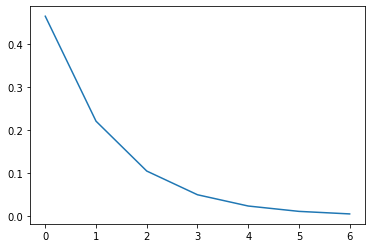

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD

0.005368709120000003

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                      Close              \
        ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
0  116.809998  182.250000  711.190002    NaN  116.809998  182.250000   
1  116.699997  182.369995  710.549988    NaN  116.699997  182.369995   
2  115.440002  181.940002  703.679993    NaN  115.440002  181.940002   
3  115.720001  182.320007  705.369995    NaN  115.720001  182.320007   
4  117.190002  183.660004  713.619995    NaN  117.190002  183.660004   

                            High              ... DayToDayChange  \
         ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  711.190002    NaN  117.699997  182.250000  ...            NaN   
1  710.549988    NaN  118.160004  182.369995  ...            NaN   
2  703.679993    NaN  117.139999  181.940002  ...            NaN   
3  705.369995    NaN  115.870003  182.320007  ...            NaN   
4  713.619995    NaN  117.250000  183.660004  ...            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1             NaN      NaN            NaN            NaN             NaN   
2             NaN      NaN            NaN            NaN             NaN   
3             NaN      NaN            NaN            NaN             NaN   
4             NaN      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

10081   2022-04-08
10082   2022-04-11
10083   2022-04-12
10084   2022-04-13
10085   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                      Close              \
                 ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
Date                                                                            
1982-04-16  116.809998  182.250000  711.190002    NaN  116.809998  182.250000   
1982-04-19  116.699997  182.369995  710.549988    NaN  116.699997  182.369995   
1982-04-20  115.440002  181.940002  703.679993    NaN  115.440002  181.940002   
1982-04-21  115.720001  182.320007  705.369995    NaN  115.720001  182.320007   
1982-04-22  117.190002  183.660004  713.619995    NaN  117.190002  183.660004   

                                     High              ... DayToDayChange  \
                  ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
Date                                                   ...                  
1982-04-16  711.190002    NaN  117.699997  182.250000  ...            NaN   
1982-04-19  710.549988    NaN  118.160004  182.369995  ...            NaN   
1982-04-20  703.679993    NaN  117.139999  181.940002  ...            NaN   
1982-04-21  705.369995    NaN  115.870003  182.320007  ...            NaN   
1982-04-22  713.619995    NaN  117.250000  183.660004  ...            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                    ^W5000    mine1          mine1          mine1   
Date                                                                
1982-04-16             NaN      NaN            NaN            NaN   
1982-04-19             NaN      NaN            NaN            NaN   
1982-04-20             NaN      NaN            NaN            NaN   
1982-04-21             NaN      NaN            NaN            NaN   
1982-04-22             NaN      NaN            NaN            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                     mine1    mine2          mine2          mine2   
Date                                                                
1982-04-16             NaN      NaN            NaN            NaN   
1982-04-19             NaN      NaN            NaN            NaN   
1982-04-20             NaN      NaN            NaN            NaN   
1982-04-21             NaN      NaN            NaN            NaN   
1982-04-22             NaN      NaN            NaN            NaN   

           OvernightChange  
                     mine2  
Date                        
1982-04-16             NaN  
1982-04-19             NaN  
1982-04-20             NaN  
1982-04-21             NaN  
1982-04-22             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.916343263900336
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.916343263900336
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.916343263900336
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Cont

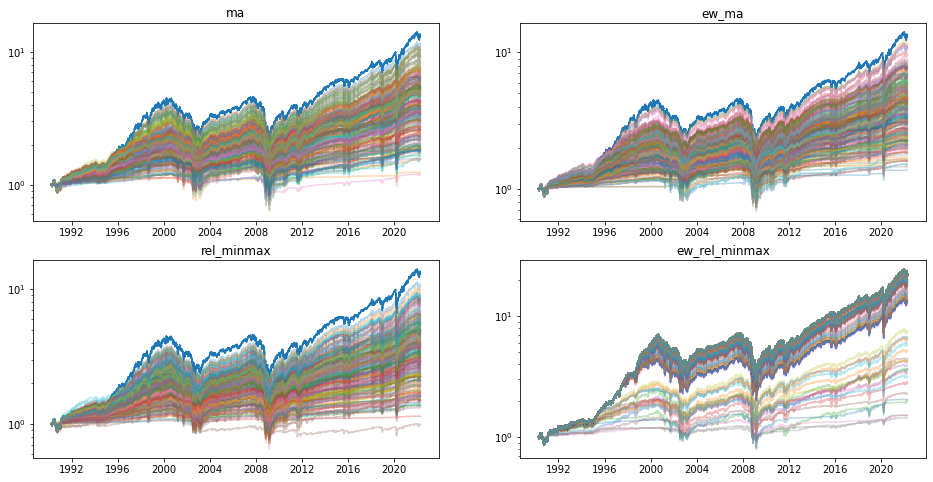

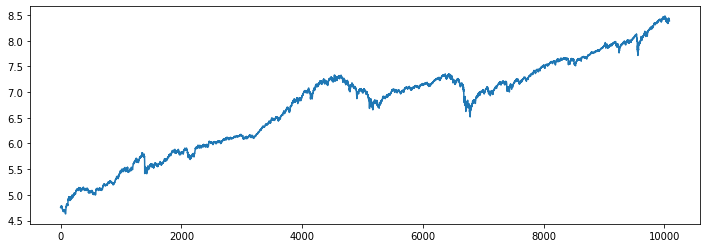

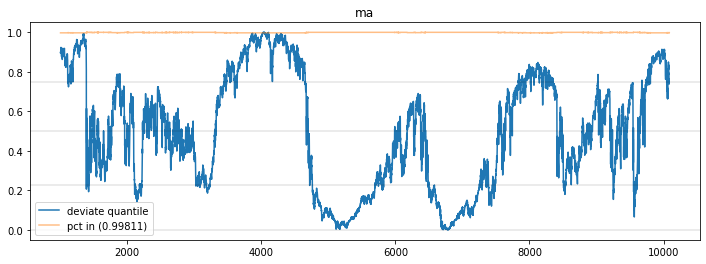

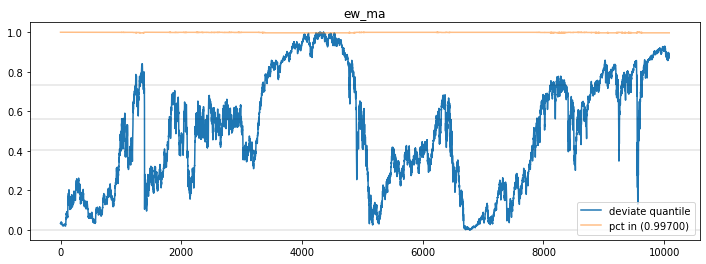

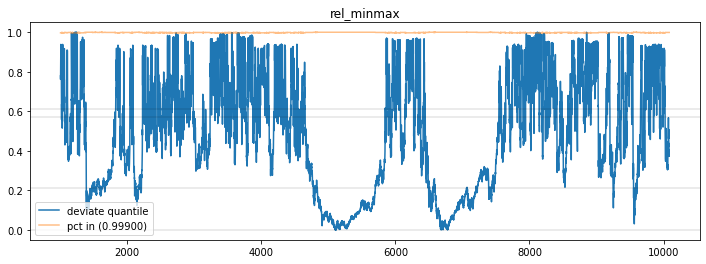

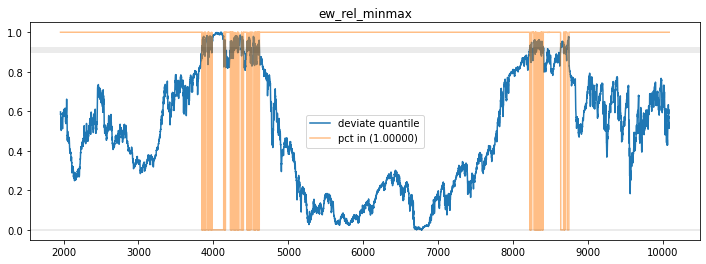

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 30.984173282054737
Refitting current best...
Current best ma returns: 36.559144281430555
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 36.78639049652702
Invested: 1.0
New best: 36.828300294707674
Invested: 1.0
New best: 36.94574517001601
Invested: 1.0
New best: 36.94575871885847
Invested: 1.0
New best: 36.945873734308606
Invested: 1.0
New best: 37.11521173309424
Invested: 1.0
New best: 37.1154237832078
Invested: 1.0
New best: 37.116223920241666
Invested: 1.0
New best: 37.11623135897156
Invested: 1.0
New best: 37.116364635268454
Invested: 1.0
Round: 180


Beginning ew_ma method...
------------------------------------

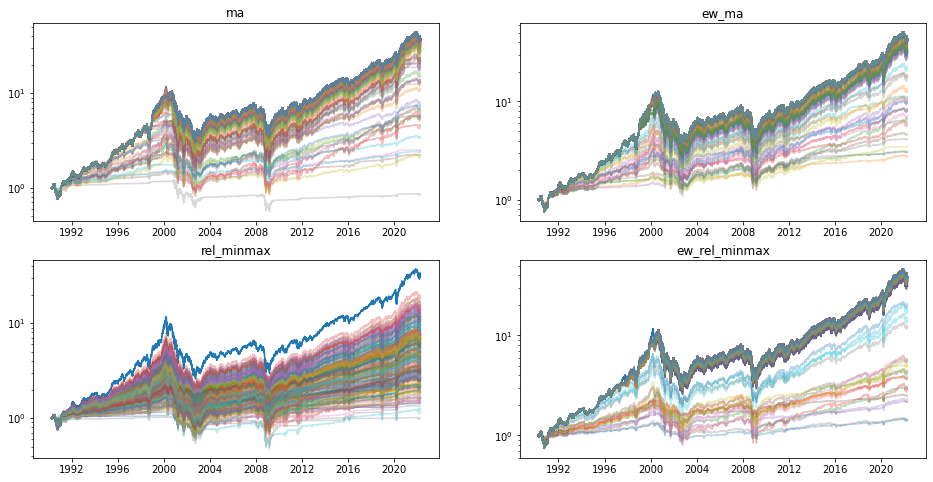

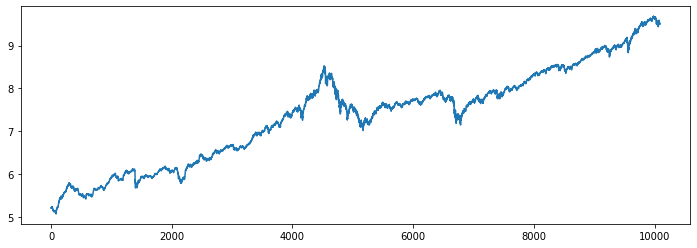

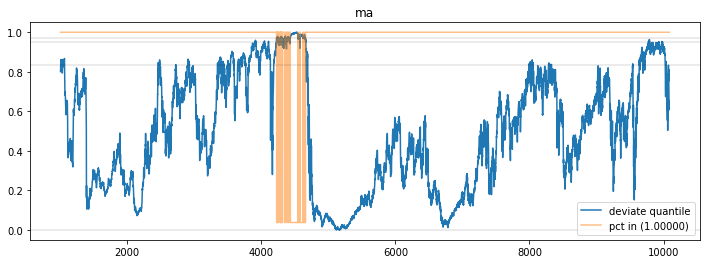

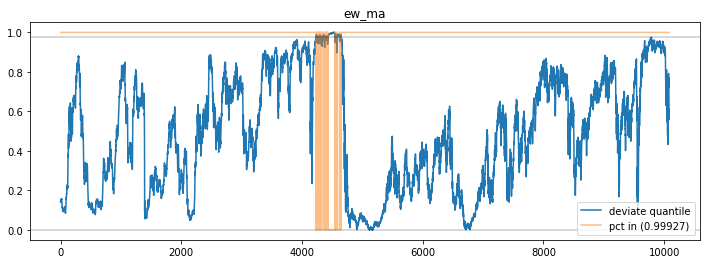

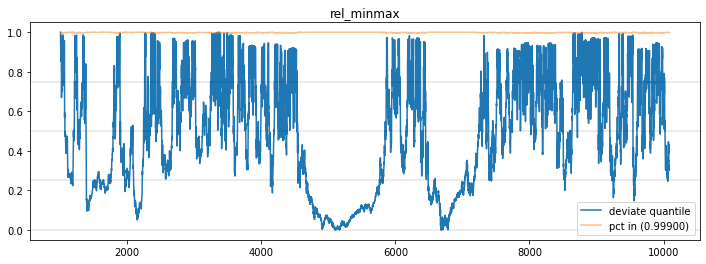

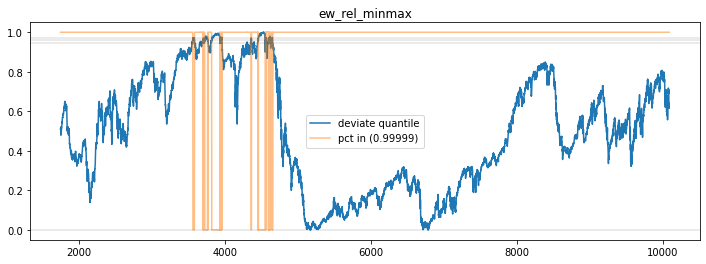

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 8.360427599649716
Refitting current best...
Current best ma returns: 8.859111905154542
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 8.930025080976908
Invested: 1.0
New best: 8.930061455017508
Invested: 1.0
New best: 8.930099239673236
Invested: 1.0
New best: 8.930131665009412
Invested: 1.0
New best: 8.930146025034807
Invested: 1.0
New best: 8.938114001008072
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 8.360427599649716
Refitting current best...
Current best ew_ma returns: 10.66212183937568
Fraction Invested: 0.9999933756284691
Beginning r

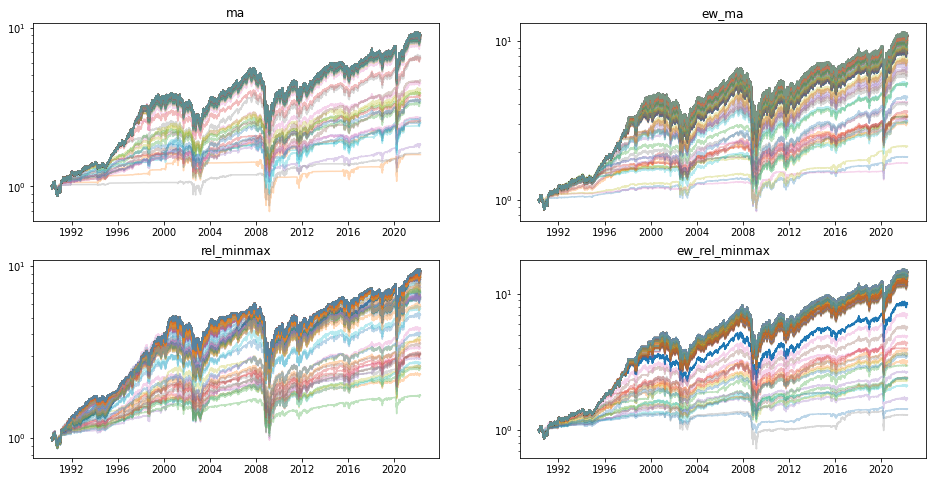

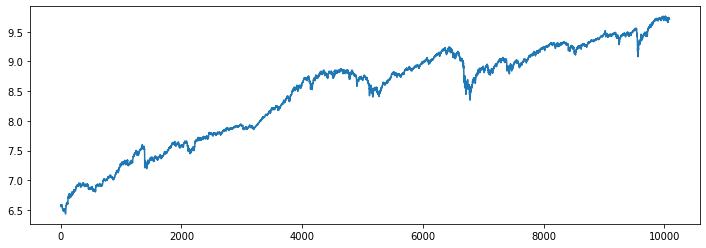

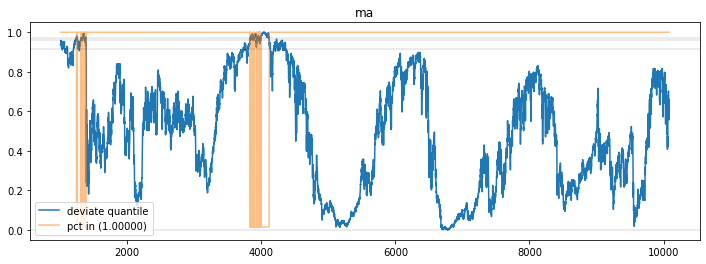

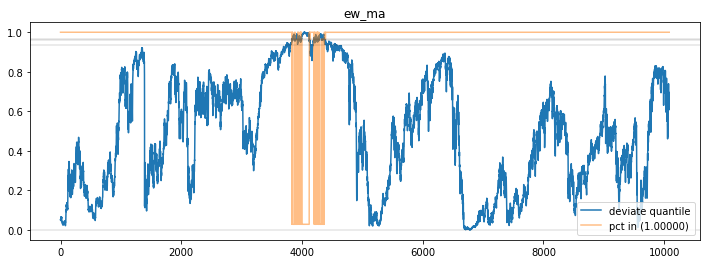

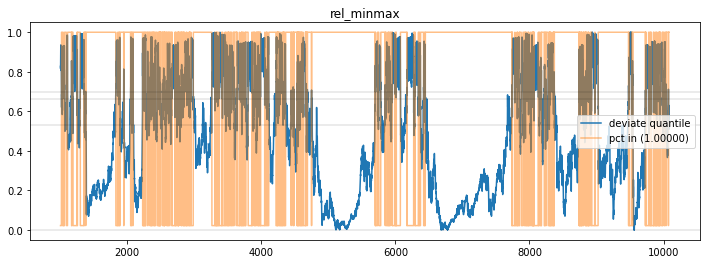

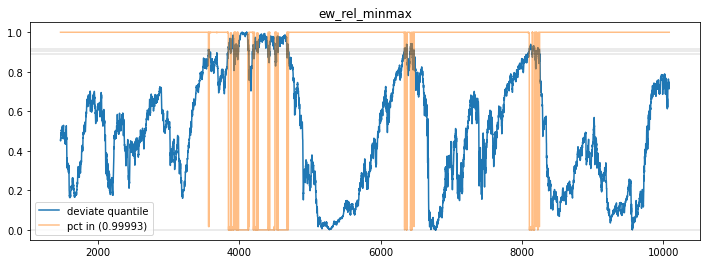

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.937445315267407
Refitting current best...
Current best ma returns: 9.82139575124187
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 9.821743247007836
Invested: 1.0
New best: 9.875407508207859
Invested: 1.0
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.937445315267407
Refitting current best...
Current best ew_ma returns: 13.315609327211705
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 7.9374453152

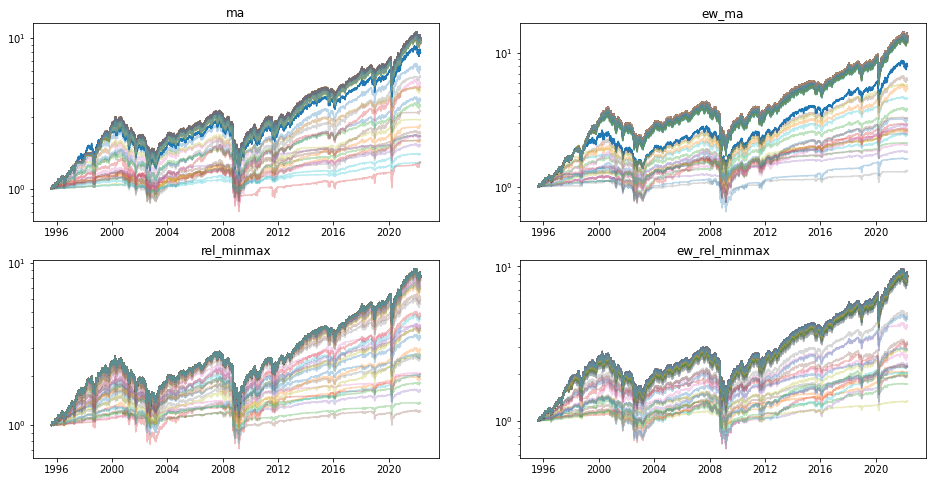

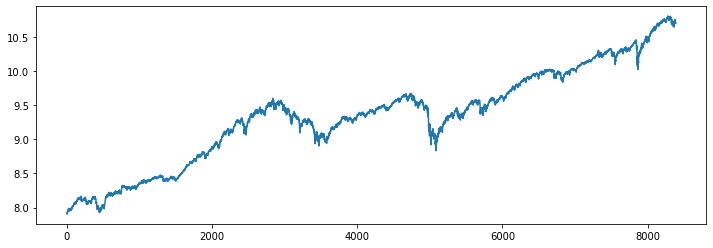

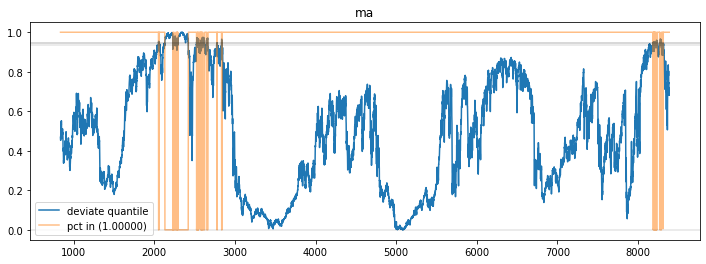

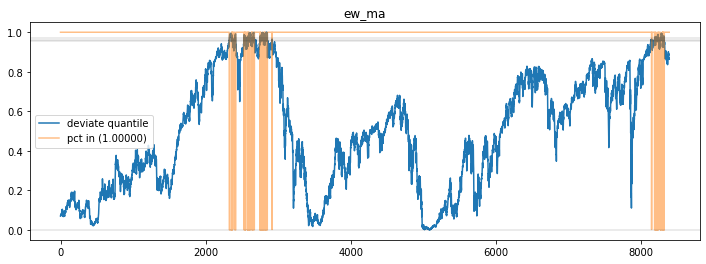

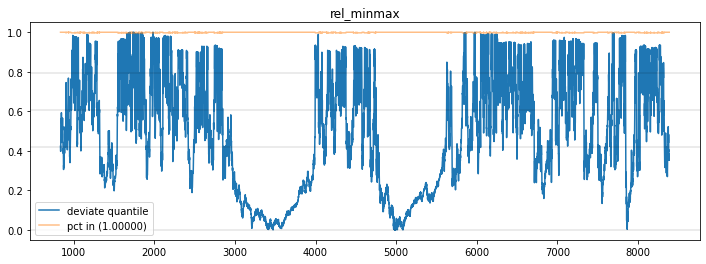

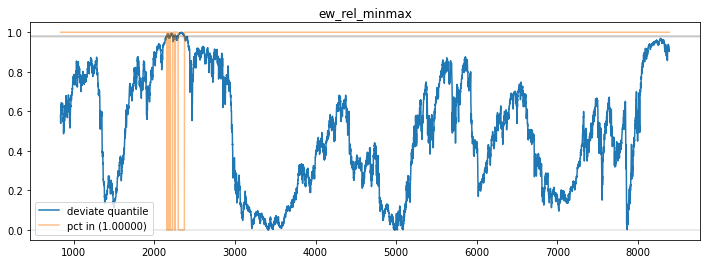

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ma returns: 14.287402323576003
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ew_ma returns: 15.137226878802354
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Fraction Invested: 1
Beginning random search..

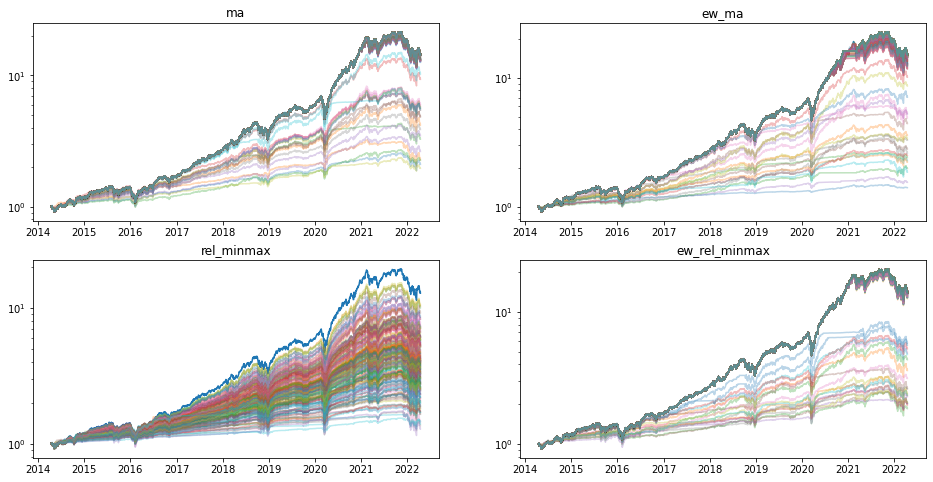

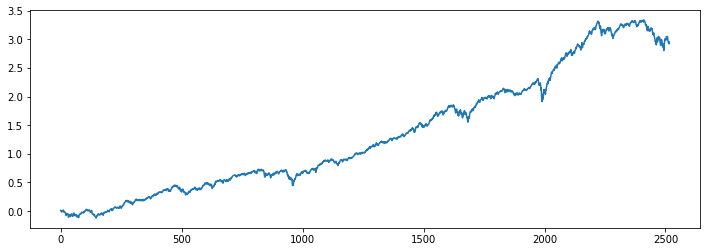

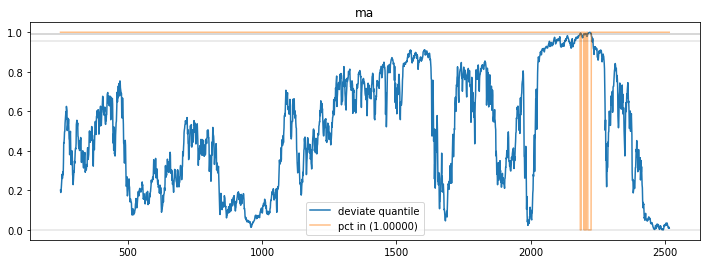

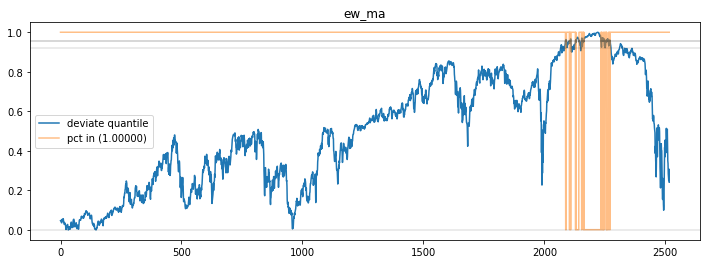

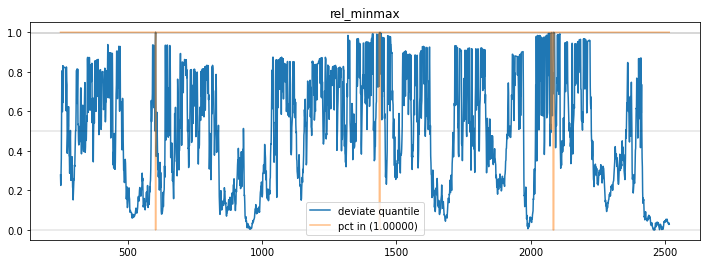

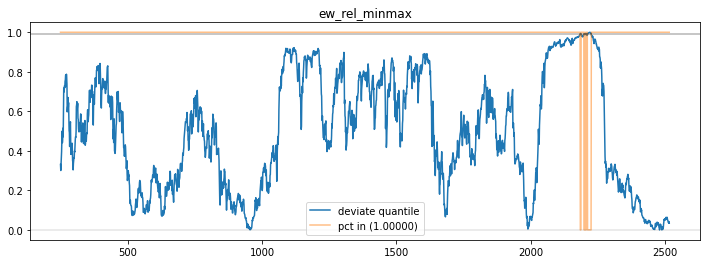

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ma returns: 6.490698163411635
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ew_ma returns: 7.296797271556346
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 7.297892045940924
Invested: 1.0
New best: 7.333328051405095
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.9383832526

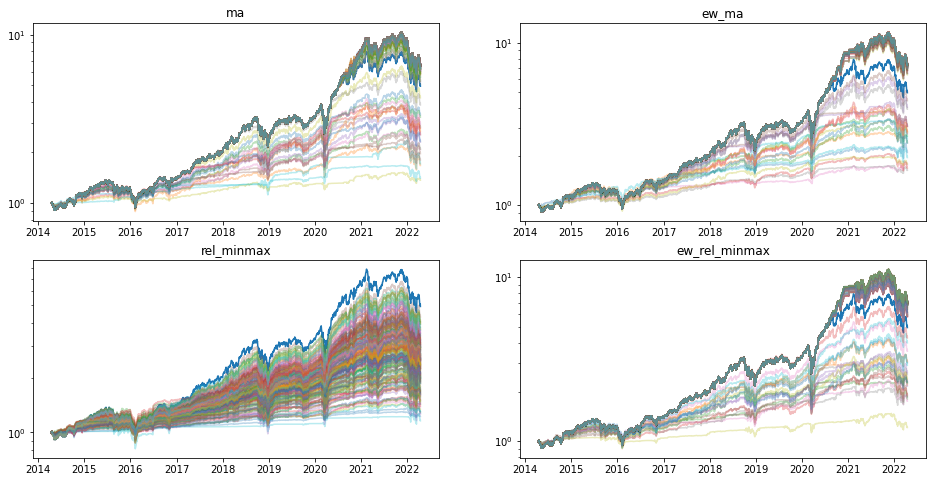

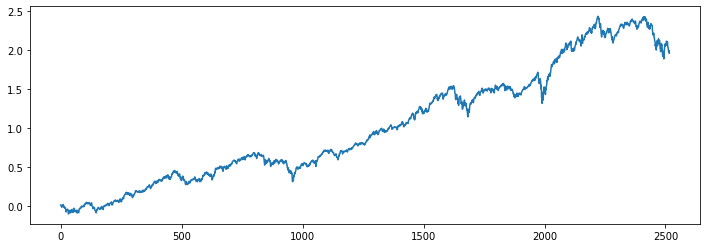

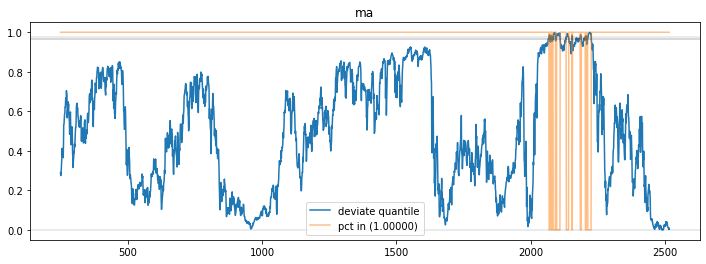

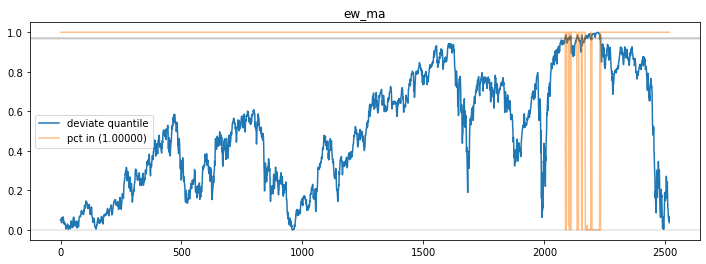

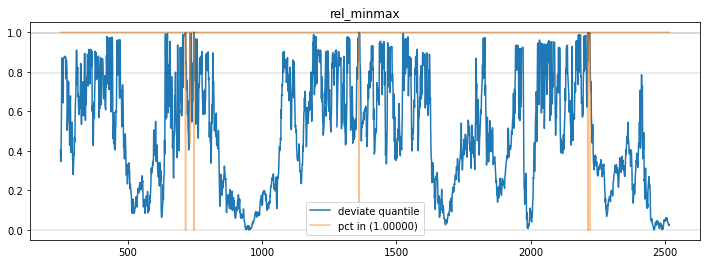

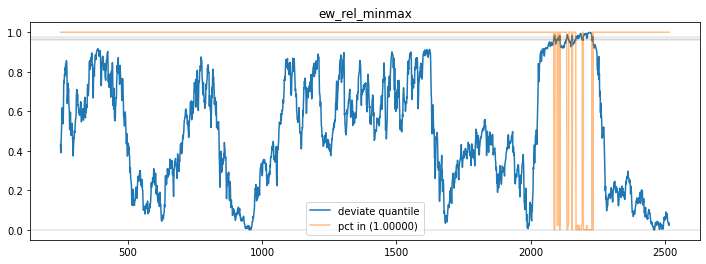

Saving mine2 params...


In [33]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [34]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [35]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 22.339355585632454 (ew_rel_minmax)
  0.99999597 in
time param: 1961
qs:
(0.0000 - 0.9011): 1.0000
(0.9011 - 0.9094): 0.9987
(0.9094 - 0.9221): 0.9987
(0.9221 - 1.0000): 0.0002

^IXIC:
  Best Return: 42.45368439947393 (ew_ma)
  0.99927052 in
time param: 315
qs:
(0.0000 - 0.0002): 1.0000
(0.0002 - 0.9758): 0.9993
(0.9758 - 0.9761): 0.9947
(0.9761 - 1.0000): 0.0011

^NYA:
  Best Return: 14.409933416771217 (ew_rel_minmax)
  0.99993013 in
time param: 1473
qs:
(0.0000 - 0.8911): 0.9999
(0.8911 - 0.9063): 0.9968
(0.9063 - 0.9175): 0.0169
(0.9175 - 1.0000): 0.0001

^W5000:
  Best Return: 13.315609327211705 (ew_ma)
  1.00000000 in
time param: 838
qs:
(0.0000 - 0.9569): 1.0000
(0.9569 - 0.9625): 1.0000
(0.9625 - 0.9727): 0.0023
(0.9727 - 1.0000): 0.0001

mine1:
  Best Return: 15.137226878802354 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9213): 1.0000
(0.9213 - 0.9560): 1.0000
(0.9560 - 0.9562): 0.9995
(0.9562 - 1.0000): 0.0012

mine2:
  Best Return: 7.33332805

{'^GSPC': {'best_return': 22.339355585632454, 'pct_in': 0.9999959720203087},
 '^IXIC': {'best_return': 42.45368439947393, 'pct_in': 0.9992705212032629},
 '^NYA': {'best_return': 14.409933416771217, 'pct_in': 0.9999301271700618},
 '^W5000': {'best_return': 13.315609327211705, 'pct_in': 1.0},
 'mine1': {'best_return': 15.137226878802354, 'pct_in': 1.0},
 'mine2': {'best_return': 7.333328051405095, 'pct_in': 1.0}}

In [36]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 22.339355585632454,
  'pct_in': 0.9999959720203087,
  'weight': 0.7295418005859546},
 '^IXIC': {'best_return': 42.45368439947393,
  'pct_in': 0.9992705212032629,
  'weight': 0.3701732175653061},
 '^NYA': {'best_return': 14.409933416771217,
  'pct_in': 0.9999301271700618,
  'weight': 0.7235880874532019},
 '^W5000': {'best_return': 13.315609327211705,
  'pct_in': 1.0,
  'weight': 0.6775686380603569},
 'mine1': {'best_return': 15.137226878802354,
  'pct_in': 1.0,
  'weight': 0.08564829679580188},
 'mine2': {'best_return': 7.333328051405095,
  'pct_in': 1.0,
  'weight': 0.24248267866389095}}

In [37]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [38]:
!say qp is dunzo